In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [112]:
def GBM_exact(T, K, S, sigma, r, M):
    S_all = []
    S_all.append(S)
    dt = T/M
    Z_all = []
    for i in range(M-1):
        Zm = np.random.normal()
        Z_all.append(Zm)
        S_all.append(S_all[i] * np.exp((r-0.5*sigma**2) * dt + sigma * np.sqrt(dt) * Zm)) 
    return S_all, Z_all

In [113]:
def GBM_Euler(T, K, S, sigma, r, M, Z_all = None):
    S_all = []
    S_all.append(S)
    dt = T/M
    for i in range(M-1):
        if Z_all:
            Zm = Z_all[i]
        else:
            Zm = np.random.normal()
        S_all.append(S_all[i] + r* S_all[i] * dt + sigma * S_all[i] * np.sqrt(dt) * Zm) 
    return S_all

In [108]:
T = 1
K = 99
S = 100
sigma = 0.2
r = 0.06

In [121]:
GBM_exact(T, K, S, sigma, r, M)[0]

[100,
 105.5214280558587,
 104.00025647212536,
 105.21495303436407,
 100.07772798833442,
 102.67374673602826,
 101.94367431257466,
 102.37511854953053,
 101.63897927488154,
 100.4596693374845,
 102.16245188033935,
 102.54924275894939,
 101.4830709141218,
 104.13206053378202,
 106.2223941929464,
 105.21668746598529,
 102.70980922500362,
 101.4143582859005,
 103.0644644844679,
 107.17842523074872,
 103.93952791353954,
 106.28812793331933,
 105.7766581696322,
 106.5136032769063,
 108.03841391892358,
 109.37782121865207,
 109.0964109039878,
 103.64171870414118,
 105.06513433968586,
 101.01439762324851,
 99.84342969351759,
 94.09631062777972,
 93.10067974256464,
 91.74961439215372,
 99.12716531648228,
 95.02047926405118,
 92.90140499944219,
 95.75457222631472,
 100.04063649798628,
 100.89049190671916,
 93.60527928569947,
 96.30495460363295,
 97.18114986394122,
 100.55076525353319,
 103.4473237088063,
 102.87095969182262,
 105.89878363410259,
 103.87414810530227,
 102.85039036098074,
 95.851

In [125]:
M=52
s_all = [GBM_Euler(T, K, S, sigma, r, M) for x in range(1000)]
s_all_exact = [GBM_exact(T, K, S, sigma, r, M)[0] for x in range(1000)]

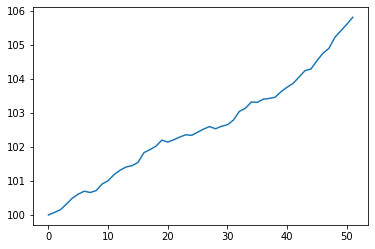

In [126]:
arrays = [np.array(x) for x in s_all]
plt.plot([np.mean(k) for k in zip(*arrays)])

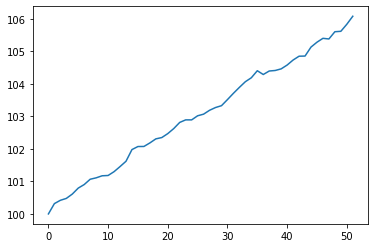

In [127]:
arrays = [np.array(x) for x in s_all_exact]
plt.plot([np.mean(k) for k in zip(*arrays)])

In [128]:
s_all_exact, Z_all = GBM_exact(T, K, S, sigma, r, M)
s_all = GBM_Euler(T, K, S, sigma, r, M, Z_all)

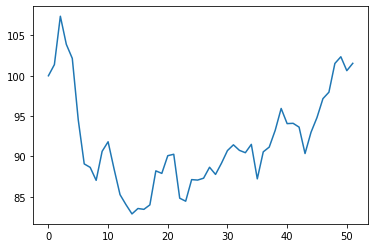

In [129]:
plt.plot(s_all_exact)

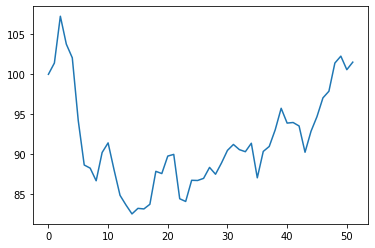

In [130]:
plt.plot(s_all)